<a href="https://colab.research.google.com/github/tanakakao/studymemo/blob/main/vit_keras_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NameError: ignored

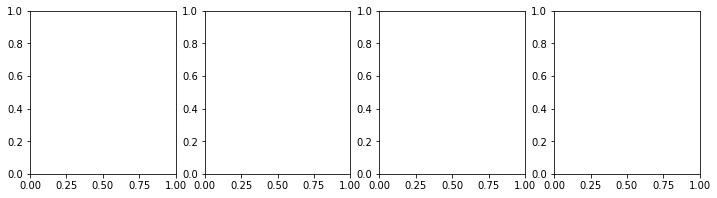

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Conv2D, Activation, Dropout, LayerNormalization, Reshape, MultiHeadAttention, RepeatVector, Concatenate
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
 
from keras import backend as K

import numpy as np
import pandas as pd
import math
import time

import matplotlib.pyplot as plt
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import cv2

# データセットの読み込み
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# バッチサイズ、クラス数、エポック数の設定
#batch_size=32
#num_classes=10
#epochs=5

# データリサイズ
#img_rows=224
#img_cols=224

#x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train[::5,:,:,:]])
#x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test[::5,:,:,:]])

# データ正規化
#x_train=x_train.astype('float32')
#x_train/=255
#x_test=x_test.astype('float32')
#x_test/=255

# one-hotベクトル化
#y_train = y_train[::5]
#y_test = y_test[::5]
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(x_train[i]) for i in range(4)];

In [ ]:
import os
print(len(os.listdir("/content/drive/MyDrive/PetImages/train/Dog")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/train/Cat")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/val/Dog")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/val/Cat")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/test/Dog")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/test/Cat")))

7000
7000
3000
3000
621
2396


In [ ]:
import shutil
import os

#!unzip kagglecatsanddogs_5340.zip
#!cp -rp "PetImages" "/content/drive/My Drive/"

unzip:  cannot find or open kagglecatsanddogs_5340.zip, kagglecatsanddogs_5340.zip.zip or kagglecatsanddogs_5340.zip.ZIP.
cp: cannot stat 'PetImages': No such file or directory


In [ ]:
os.makedirs('/content/drive/MyDrive/PetImages/train/Dog', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/train/Cat', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/val/Dog', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/val/Cat', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/test/Dog', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/test/Cat', exist_ok=True)

In [ ]:

for i in range(12001,13001)[::-1]:
  try:
    shutil.move("/content/drive/MyDrive/PetImages/Cat/"+str(i)+".jpg", '/content/drive/MyDrive/PetImages/test/Cat')
  except:
    continue
  try:
    shutil.move("/content/drive/MyDrive/PetImages/Dog/"+str(i)+".jpg", '/content/drive/MyDrive/PetImages/test/Dog')
  except:
    continue
  #if len(os.listdir("/content/drive/MyDrive/PetImages/val/Dog"))==3000:
  #  break

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Conv2D, Activation, Dropout, LayerNormalization, Reshape, RepeatVector, Concatenate
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
 
from keras import backend as K

import numpy as np
import pandas as pd
import math
import time

import matplotlib.pyplot as plt
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import cv2

In [11]:
class patch_embbeding(Layer):
    def __init__(self, img_size, patch_size=4, hidden_dim=8):
        super().__init__()
        self.D = hidden_dim
        
        self.patch_conv = Conv2D(filters = hidden_dim, kernel_size = (patch_size,patch_size), strides=patch_size, padding = 'same', activation='gelu')
        
        # [class]追加
        self.cls_token = self.add_weight(
            shape=(1,1,hidden_dim), initializer="random_normal", trainable=True, name='class', dtype=tf.float32
        )

        # position encoding
        self.position = self.add_weight(
            shape=(int(img_size[0]*img_size[1]/(patch_size*patch_size))+1,self.D), initializer="random_normal", trainable=True, name='position', dtype=tf.float32
        )
        
        self.repeat = RepeatVector
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        out = self.patch_conv(inputs)
        out = Reshape((-1,self.D))(out)
        cls = tf.broadcast_to(self.cls_token, [batch_size, 1, self.D])
        out = Concatenate(axis=1)([cls, out])
        out = out+self.position 
        return out

class SelfMultiHeadAttention(Layer):
    '''
    Multi-Head Attentionレイヤ

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, drop_rate=0.5):
        '''
        Multi-Head Attentionレイヤ
    
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : マルチヘッドAttentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''

        super(SelfMultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = Conv1D(hidden_dim, kernel_size=1)
        self.key   = Conv1D(hidden_dim, kernel_size=1)
        self.value = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力の線形変換
        self.projection = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力のDropout
        self.drop = Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask, training):
        """
        Attention
        
        query, key, value : クエリ、キー、バリュー
            query [batch_size, head_num, q_length, hidden_dim//head_num]
            key, value [batch_size, head_num, m_length, hidden_dim//head_num]
            ただし、encoder:q_length=m_length
                   decoder:mask multihead attentionではq_length=m_length
                           2つ目のmultihead attentionではq_length≠m_length
        attention_mask : attention weight に適用される mask
            encoder : [1, 1, q_length, q_length]
            decoder : [1, 1, m_length, m_length]
        """
        # 各値を取得
        shape = query.shape.as_list() # batch_size, head_num, q_length, hidden_dim//head_num
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数(q_length)
        hidden_dim = shape[1]*shape[3] # 特徴ベクトルの長さ(head_num × hidden_dim//head_num = hidden_dim)
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [batch_size, head_num, q_length, hidden_dim/head_num] @ [batch_size, head_num, hidden_dim/head_num, m_length] = [batch_size, head_num, q_length, m_length]
        scores = tf.matmul(query, key, transpose_b=True)
        
        # scoreをhidden_dimの平方根割る
        scores = tf.multiply(scores, tf.math.rsqrt(tf.cast(hidden_dim, tf.float32)))
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [1, 1, (q|m)_length, (q|m)_length] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 1の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする
        if attention_mask is not None:
            scores = scores + attention_mask * -1e9
        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = tf.nn.softmax(scores, axis=-1)
        
        # 重みに従って value から情報を引いてきます
        # [batch_size, head_num, q_length, m_length] @ [batch_size, head_num, m_length, hidden_dim/head_num] = [batch_size, head_num, q_length, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = tf.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        # [batch_size, head_num, q_length, hidden_dim/head_num] -> [batch_size, q_length, head_num, hidden_dim/head_num]
        context = tf.transpose(context, [0, 2, 1, 3])
        # [batch_size, q_length, head_num, hidden_dim/head_num] -> [batch_size, q_length, hidden_dim]
        context = tf.reshape(context, (batch_size, token_num, hidden_dim))
        
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim]
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = tf.reshape(x, (batch_size, token_num, heads_num, int(hidden_dim/heads_num)))
        
        # [batch_size, (q|m)_length, head_num, hidden_dim/head_num] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        x = tf.transpose(x, [0, 2, 1, 3])
        return x
    
    def call(self, x, training, memory, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x

        # input -> query
        # memory -> key, value
        # [batch_size, (q|m)_length, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, (q|m)_length, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, q_length, hidden_dim]
        # score_weightsはEncoderではNoneとする
        context, attn_weights = self.atten(query, key, value, attention_mask, training)
        if not return_attention_scores:
            return context
        else:
            return context, attn_weights

class FeedForwardNetwork(Layer):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate):
        '''
        hidden_dim : Embeddingされた単語ベクトルの長さ
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation='gelu')
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = Dense(hidden_dim, use_bias=True)
        self.drop = Dropout(drop_rate)

    def call(self, x, training):
        '''
        入力と出力で形が変わらない
        x : 入力 [batch_size, length, hidden_dim]
        '''
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.drop(x, training=training)
        
        # [batch_size, (q|m)_length, 4*hidden_dim] -> [batch_size, (q|m)_length, hidden_dim]
        return self.output_dense_layer(x)

class ResidualNormalizationWrapper(Layer):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, drop_rate):
        '''
        layer : 残渣接続したいレイヤ(MultiHeadAttentionかFeedForwardNetwork)に適用
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = LayerNormalization()
        self.drop = Dropout(drop_rate)

    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=None):
        """
        モデルの実行
        
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのlengthと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            # attention weightを返す
            out, attn_weights = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out, attn_weights
        else:
            # attention weightを返さない
            out = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out

class EncoderLayer(Layer):
    """
    Encoderレイヤ
    　MultiHeadAttentionとFeedForwardNetworkの組み合わせ
      それぞれ残差接続されている
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # Multi-head attention
        self.atten = ResidualNormalizationWrapper(
            layer = SelfMultiHeadAttention(hidden_dim = hidden_dim,
                                           heads_num = heads_num,
                                           drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # Feed Forward Network
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        if return_attention_scores:
            x, attn_weights = self.atten(input,training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

class Encoder(Layer):
    '''
    TransformerのEncoder
    '''
    def __init__(self, img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.patch_embbeding = patch_embbeding(img_size=img_size, patch_size=patch_size, hidden_dim=hidden_dim)
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [EncoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(self, input, training, attention_mask=None, return_attention_scores=False):
        '''
        input: 入力 [batch_size, q_length, hidden_dim]
        memory: 入力 [batch_size, m_length, hidden_dim]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, q_length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.patch_embbeding(input)
        query = self.input_dropout_layer(embedded_input, training=training)

        # Encoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, training, embedded_input, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, embedded_input, attention_mask, return_attention_scores)
                #print(query.shape)
            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

class VisionTransformer(Model):
    """
    Transformerベースの時系列予測モデル
    
    """
    def __init__(self, img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.encoder = Encoder(img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate)
        
        # 全結合層
        self.fc1 = Dense(16, activation='tanh')
        self.dropout1 = Dropout(drop_rate)
   
        self.final_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, return_attention_scores=False):
        '''
        inputs: 入力(encoder, decoder)
        return_attention_scores : attention weightを出力するか
        '''
        # Encoderの出力はDecoderへの入力(memory)となる
        # enc_input : [batch_size, enc_length, hidden_dim]
        if return_attention_scores:
            enc_output, enc_atten_weights = self.encoder(inputs, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(inputs, attention_mask=None,return_attention_scores=return_attention_scores)
         
        # [batch_size, dec_length, hidden_dim] -> [batch_size, dec_length]
        class_output = enc_output[:,0,:]
        
        fc_output = self.fc1(class_output)
        fc_output = self.dropout1(fc_output)
        final_output = self.final_layer(fc_output)

        if return_attention_scores:
            return final_output, enc_atten_weights
        else:
            return final_output

In [ ]:
batch_size=25
epochs = 120
initial_lrate = 0.001

# Checkpoint -- ベストのモデルのみ保存
modelCheckpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/dogcat_mini/",
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False, # 重みのみ保存
                                  mode='max', # val_accuracyの場合
                                  period=1)

def decay(epoch, steps=50):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate <= 1e-6:
      lrate=1e-6
    return lrate

sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, weight_decay=0.1)

lr_sc = LearningRateScheduler(decay, verbose=1)

model = VisionTransformer(img_size=(224,224), patch_size=4, hopping_num=4, heads_num=2, hidden_dim=32, drop_rate=0.1)
model.compile(loss=['binary_crossentropy'], optimizer=sgd,  metrics=['accuracy'])

NameError: ignored

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

batch_size=25
img_height = 224
img_width = 224

classes = ['Dog', 'Cat']

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   channel_shift_range=True,
                                   zoom_range=[0.5, 2.0],
                                   rotation_range=10,
                                   height_shift_range = 0.1,
                                   width_shift_range = 0.1,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/train',
        target_size=(img_height, img_width),
        color_mode = 'rgb', #グレー:'grayscale'
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',#2つ'binary' 3つ以上:'categorical'
        save_format='jpeg'
)

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',
        save_format='jpeg')

Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
model.build((None, 224, 224, 3))  # build with input shape.
dummy_input = Input(shape=(224, 224, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 encoder_15 (Encoder)        (None, 3137, 32)          152864    
                                                                 
 tf.__operators__.getitem_2   (None, 32)               0         
 (SlicingOpLambda)                                               
                                                                 
 dense_138 (Dense)           (None, 16)                528       
                                                                 
 dropout_252 (Dropout)       (None, 16)                0         
                                                                 
 dense_139 (Dense)           (None, 1)                 17        
                                                           

In [ ]:
history=model.fit(train_generator,
                  #batch_size=batch_size,
                  epochs=epochs,
                  #steps_per_epoch=int(len(x_train)//batch_size),
                  validation_data=validation_generator,
                  #validation_steps=int(len(x_test)//batch_size),
                  callbacks = [modelCheckpoint, lr_sc]
                  )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/120
200/200 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.4946
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 1928s 10s/step - loss: 0.7200 - accuracy: 0.4946 - val_loss: 0.6941 - val_accuracy: 0.5000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/120
200/200 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.4962
Epoch 2: val_accuracy improved from 0.50000 to 0.56950, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 105s 524ms/step - loss: 0.7130 - accuracy: 0.4962 - val_loss: 0.6925 - val_accuracy: 0.5695 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/120
200/200 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.4994
Epoch 3: val_accuracy did not improve from 0.56950
200/200 [==============================] - 97s 484ms/step - loss: 0.7100 - accuracy: 0.4994 - val_loss: 0.7078 - val_accuracy: 0.5000 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/120
200/200 [==============================] - ETA: 0s - loss: 0.7043 - accuracy: 0.5030
Epoch 4: val_accuracy improved from 0.56950 to 0.58550, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 103s 514ms/step - loss: 0.7043 - accuracy: 0.5030 - val_loss: 0.6827 - val_accuracy: 0.5855 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/120
200/200 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5396
Epoch 5: val_accuracy improved from 0.58550 to 0.59300, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 102s 509ms/step - loss: 0.6908 - accuracy: 0.5396 - val_loss: 0.6763 - val_accuracy: 0.5930 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/120
200/200 [==============================] - ETA: 0s - loss: 0.6823 - accuracy: 0.5672
Epoch 6: val_accuracy improved from 0.59300 to 0.61000, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 103s 513ms/step - loss: 0.6823 - accuracy: 0.5672 - val_loss: 0.6640 - val_accuracy: 0.6100 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.001.
Epoch 7/120
200/200 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.5738
Epoch 7: val_accuracy did not improve from 0.61000
200/200 [==============================] - 94s 471ms/step - loss: 0.6774 - accuracy: 0.5738 - val_loss: 0.6661 - val_accuracy: 0.5915 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.001.
Epoch 8/120
200/200 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.5886
Epoch 8: val_accuracy improved from 0.61000 to 0.61350, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 103s 515ms/step - loss: 0.6687 - accuracy: 0.5886 - val_loss: 0.6592 - val_accuracy: 0.6135 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.001.
Epoch 9/120
200/200 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.5940
Epoch 9: val_accuracy did not improve from 0.61350
200/200 [==============================] - 94s 468ms/step - loss: 0.6622 - accuracy: 0.5940 - val_loss: 0.6472 - val_accuracy: 0.6085 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.001.
Epoch 10/120
200/200 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.6012
Epoch 10: val_accuracy improved from 0.61350 to 0.63050, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 102s 511ms/step - loss: 0.6610 - accuracy: 0.6012 - val_loss: 0.6444 - val_accuracy: 0.6305 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.001.
Epoch 11/120
200/200 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.5982
Epoch 11: val_accuracy did not improve from 0.63050
200/200 [==============================] - 94s 467ms/step - loss: 0.6583 - accuracy: 0.5982 - val_loss: 0.6506 - val_accuracy: 0.6205 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.001.
Epoch 12/120
200/200 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.5936
Epoch 12: val_accuracy did not improve from 0.63050
200/200 [==============================] - 95s 474ms/step - loss: 0.6598 - accuracy: 0.5936 - val_loss: 0.6407 - val_accuracy: 0.6160 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.001.
Epoch 13/120
200/200 [==============================] - ETA: 0s

200/200 [==============================] - 103s 514ms/step - loss: 0.6554 - accuracy: 0.6038 - val_loss: 0.6514 - val_accuracy: 0.6420 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.001.
Epoch 16/120
200/200 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.6038
Epoch 16: val_accuracy did not improve from 0.64200
200/200 [==============================] - 93s 465ms/step - loss: 0.6560 - accuracy: 0.6038 - val_loss: 0.6372 - val_accuracy: 0.6185 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.001.
Epoch 17/120
200/200 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.6072
Epoch 17: val_accuracy did not improve from 0.64200
200/200 [==============================] - 94s 469ms/step - loss: 0.6516 - accuracy: 0.6072 - val_loss: 0.6535 - val_accuracy: 0.5885 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.001.
Epoch 18/120
200/200 [==============================] - ETA: 0s

200/200 [==============================] - 104s 519ms/step - loss: 0.6395 - accuracy: 0.6292 - val_loss: 0.6170 - val_accuracy: 0.6475 - lr: 0.0010

Epoch 27: LearningRateScheduler setting learning rate to 0.001.
Epoch 27/120
200/200 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.6382
Epoch 27: val_accuracy improved from 0.64750 to 0.65300, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 103s 513ms/step - loss: 0.6342 - accuracy: 0.6382 - val_loss: 0.6245 - val_accuracy: 0.6530 - lr: 0.0010

Epoch 28: LearningRateScheduler setting learning rate to 0.001.
Epoch 28/120
200/200 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.6380
Epoch 28: val_accuracy improved from 0.65300 to 0.66100, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 104s 520ms/step - loss: 0.6339 - accuracy: 0.6380 - val_loss: 0.6120 - val_accuracy: 0.6610 - lr: 0.0010

Epoch 29: LearningRateScheduler setting learning rate to 0.001.
Epoch 29/120
200/200 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.6494
Epoch 29: val_accuracy improved from 0.66100 to 0.66750, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 105s 522ms/step - loss: 0.6243 - accuracy: 0.6494 - val_loss: 0.6029 - val_accuracy: 0.6675 - lr: 0.0010

Epoch 30: LearningRateScheduler setting learning rate to 0.001.
Epoch 30/120
200/200 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.6416
Epoch 30: val_accuracy did not improve from 0.66750
200/200 [==============================] - 95s 475ms/step - loss: 0.6262 - accuracy: 0.6416 - val_loss: 0.6007 - val_accuracy: 0.6650 - lr: 0.0010

Epoch 31: LearningRateScheduler setting learning rate to 0.001.
Epoch 31/120
200/200 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.6526
Epoch 31: val_accuracy improved from 0.66750 to 0.67200, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 104s 520ms/step - loss: 0.6205 - accuracy: 0.6526 - val_loss: 0.5987 - val_accuracy: 0.6720 - lr: 0.0010

Epoch 32: LearningRateScheduler setting learning rate to 0.001.
Epoch 32/120
200/200 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.6548
Epoch 32: val_accuracy did not improve from 0.67200
200/200 [==============================] - 96s 477ms/step - loss: 0.6109 - accuracy: 0.6548 - val_loss: 0.6132 - val_accuracy: 0.6500 - lr: 0.0010

Epoch 33: LearningRateScheduler setting learning rate to 0.001.
Epoch 33/120
200/200 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.6508
Epoch 33: val_accuracy did not improve from 0.67200
200/200 [==============================] - 94s 470ms/step - loss: 0.6192 - accuracy: 0.6508 - val_loss: 0.5989 - val_accuracy: 0.6565 - lr: 0.0010

Epoch 34: LearningRateScheduler setting learning rate to 0.001.
Epoch 34/120
200/200 [==============================] - ETA: 0s

200/200 [==============================] - 104s 517ms/step - loss: 0.6093 - accuracy: 0.6634 - val_loss: 0.5985 - val_accuracy: 0.6790 - lr: 0.0010

Epoch 35: LearningRateScheduler setting learning rate to 0.001.
Epoch 35/120
200/200 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.6710
Epoch 35: val_accuracy did not improve from 0.67900
200/200 [==============================] - 94s 469ms/step - loss: 0.5999 - accuracy: 0.6710 - val_loss: 0.5948 - val_accuracy: 0.6760 - lr: 0.0010

Epoch 36: LearningRateScheduler setting learning rate to 0.001.
Epoch 36/120
200/200 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.6576
Epoch 36: val_accuracy improved from 0.67900 to 0.68500, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 105s 526ms/step - loss: 0.6130 - accuracy: 0.6576 - val_loss: 0.5874 - val_accuracy: 0.6850 - lr: 0.0010

Epoch 37: LearningRateScheduler setting learning rate to 0.001.
Epoch 37/120
200/200 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.6678
Epoch 37: val_accuracy improved from 0.68500 to 0.68750, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 107s 533ms/step - loss: 0.6026 - accuracy: 0.6678 - val_loss: 0.5909 - val_accuracy: 0.6875 - lr: 0.0010

Epoch 38: LearningRateScheduler setting learning rate to 0.001.
Epoch 38/120
200/200 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.6674
Epoch 38: val_accuracy improved from 0.68750 to 0.68900, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 107s 533ms/step - loss: 0.6015 - accuracy: 0.6674 - val_loss: 0.5844 - val_accuracy: 0.6890 - lr: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.001.
Epoch 39/120
200/200 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.6674
Epoch 39: val_accuracy did not improve from 0.68900
200/200 [==============================] - 98s 488ms/step - loss: 0.6003 - accuracy: 0.6674 - val_loss: 0.5863 - val_accuracy: 0.6825 - lr: 0.0010

Epoch 40: LearningRateScheduler setting learning rate to 0.001.
Epoch 40/120
200/200 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.6780
Epoch 40: val_accuracy improved from 0.68900 to 0.69050, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 109s 542ms/step - loss: 0.5985 - accuracy: 0.6780 - val_loss: 0.5780 - val_accuracy: 0.6905 - lr: 0.0010

Epoch 41: LearningRateScheduler setting learning rate to 0.001.
Epoch 41/120
200/200 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.6728
Epoch 41: val_accuracy did not improve from 0.69050
200/200 [==============================] - 98s 490ms/step - loss: 0.5975 - accuracy: 0.6728 - val_loss: 0.6049 - val_accuracy: 0.6615 - lr: 0.0010

Epoch 42: LearningRateScheduler setting learning rate to 0.001.
Epoch 42/120
200/200 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.6734
Epoch 42: val_accuracy improved from 0.69050 to 0.69950, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 109s 542ms/step - loss: 0.5949 - accuracy: 0.6734 - val_loss: 0.5755 - val_accuracy: 0.6995 - lr: 0.0010

Epoch 43: LearningRateScheduler setting learning rate to 0.001.
Epoch 43/120
200/200 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.6800
Epoch 43: val_accuracy improved from 0.69950 to 0.70250, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 111s 551ms/step - loss: 0.5934 - accuracy: 0.6800 - val_loss: 0.5733 - val_accuracy: 0.7025 - lr: 0.0010

Epoch 44: LearningRateScheduler setting learning rate to 0.001.
Epoch 44/120
200/200 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.6764
Epoch 44: val_accuracy did not improve from 0.70250
200/200 [==============================] - 99s 495ms/step - loss: 0.5941 - accuracy: 0.6764 - val_loss: 0.6298 - val_accuracy: 0.6530 - lr: 0.0010

Epoch 45: LearningRateScheduler setting learning rate to 0.001.
Epoch 45/120
200/200 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.6886
Epoch 45: val_accuracy did not improve from 0.70250
200/200 [==============================] - 94s 468ms/step - loss: 0.5863 - accuracy: 0.6886 - val_loss: 0.6072 - val_accuracy: 0.6575 - lr: 0.0010

Epoch 46: LearningRateScheduler setting learning rate to 0.001.
Epoch 46/120
200/200 [==============================] - ETA: 0s

200/200 [==============================] - 99s 495ms/step - loss: 0.5866 - accuracy: 0.6834 - val_loss: 0.5667 - val_accuracy: 0.7055 - lr: 0.0010

Epoch 47: LearningRateScheduler setting learning rate to 0.001.
Epoch 47/120
200/200 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.6918
Epoch 47: val_accuracy improved from 0.70550 to 0.71600, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 100s 497ms/step - loss: 0.5841 - accuracy: 0.6918 - val_loss: 0.5553 - val_accuracy: 0.7160 - lr: 0.0010

Epoch 48: LearningRateScheduler setting learning rate to 0.001.
Epoch 48/120
200/200 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.6942
Epoch 48: val_accuracy did not improve from 0.71600
200/200 [==============================] - 91s 455ms/step - loss: 0.5784 - accuracy: 0.6942 - val_loss: 0.5540 - val_accuracy: 0.7145 - lr: 0.0010

Epoch 49: LearningRateScheduler setting learning rate to 0.001.
Epoch 49/120
200/200 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.6998
Epoch 49: val_accuracy improved from 0.71600 to 0.72850, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 101s 504ms/step - loss: 0.5784 - accuracy: 0.6998 - val_loss: 0.5511 - val_accuracy: 0.7285 - lr: 0.0010

Epoch 50: LearningRateScheduler setting learning rate to 0.0001.
Epoch 50/120
200/200 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.7018
Epoch 50: val_accuracy did not improve from 0.72850
200/200 [==============================] - 91s 453ms/step - loss: 0.5714 - accuracy: 0.7018 - val_loss: 0.5472 - val_accuracy: 0.7205 - lr: 1.0000e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0001.
Epoch 51/120
200/200 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7154
Epoch 51: val_accuracy did not improve from 0.72850
200/200 [==============================] - 92s 457ms/step - loss: 0.5605 - accuracy: 0.7154 - val_loss: 0.5493 - val_accuracy: 0.7175 - lr: 1.0000e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0001.
Epoch 52/120
200/200 [==============================

In [ ]:
from PIL import Image
import os

for f in os.listdir("/content/drive/MyDrive/dogcat_mini/val/Dog"):
  Image.open("/content/drive/MyDrive/dogcat_mini/val/Dog/"+f)

In [12]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/dogcat_mini/model1/")

In [20]:
imgs = next(validation_generator)

result = model(imgs[0])

ValueError: ignored

In [15]:
imgs

(array([[[[0.8196079 , 0.90196085, 0.9843138 ],
          [0.8235295 , 0.9058824 , 0.9803922 ],
          [0.8235295 , 0.9058824 , 0.9803922 ],
          ...,
          [0.7960785 , 0.8941177 , 0.9725491 ],
          [0.7960785 , 0.8745099 , 0.9686275 ],
          [0.7960785 , 0.8745099 , 0.9686275 ]],
 
         [[0.81568635, 0.8980393 , 0.9803922 ],
          [0.8196079 , 0.90196085, 0.97647065],
          [0.8196079 , 0.90196085, 0.97647065],
          ...,
          [0.77647066, 0.86274517, 0.95294124],
          [0.79215693, 0.8705883 , 0.96470594],
          [0.7960785 , 0.8745099 , 0.9686275 ]],
 
         [[0.81568635, 0.8980393 , 0.9725491 ],
          [0.81568635, 0.8980393 , 0.9725491 ],
          [0.8196079 , 0.90196085, 0.97647065],
          ...,
          [0.78823537, 0.8745099 , 0.9686275 ],
          [0.7960785 , 0.882353  , 0.9725491 ],
          [0.7960785 , 0.882353  , 0.9725491 ]],
 
         ...,
 
         [[0.54509807, 0.5686275 , 0.6156863 ],
          [0.54117

In [ ]:
import tensorflow_hub as hub

model2 = tf.keras.Sequential([
                             hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False),
                             Dense(16, activation='tanh'),
                             Dropout(0.5),
                             Dense(1, activation='sigmoid')
                             ])

In [ ]:
batch_size=25
epochs = 10
initial_lrate = 0.001

# Checkpoint -- ベストのモデルのみ保存
modelCheckpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/dogcat_mini/model2/",
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False, # 重みのみ保存
                                  mode='max', # val_accuracyの場合
                                  period=1)

def decay(epoch, steps=50):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate <= 1e-6:
      lrate=1e-6
    return lrate

sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, weight_decay=0.1)

lr_sc = LearningRateScheduler(decay, verbose=1)

model2.compile(loss=['binary_crossentropy'], optimizer=sgd,  metrics=['accuracy'])

In [ ]:
history=model2.fit(train_generator,
                  #batch_size=batch_size,
                  epochs=epochs,
                  #steps_per_epoch=int(len(x_train)//batch_size),
                  validation_data=validation_generator,
                  #validation_steps=int(len(x_test)//batch_size),
                  callbacks = [modelCheckpoint, lr_sc]
                  )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9640
Epoch 1: val_accuracy improved from -inf to 0.99550, saving model to /content/drive/MyDrive/dogcat_mini/model2/
200/200 [==============================] - 128s 601ms/step - loss: 0.1038 - accuracy: 0.9640 - val_loss: 0.0208 - val_accuracy: 0.9955 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9892
Epoch 2: val_accuracy improved from 0.99550 to 0.99600, saving model to /content/drive/MyDrive/dogcat_mini/model2/
200/200 [==============================] - 115s 576ms/step - loss: 0.0396 - accuracy: 0.9892 - val_loss: 0.0184 - val_accuracy: 0.9960 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.98

In [ ]:
!pip install vit-keras
!pip install tensorflow_addons
from vit_keras import vit

image_size = 224
base_model = vit.vit_b16(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=1
)

# 学習させない
for layer in base_model.layers[:6]:
    layer.trainable = False

#model3 = tf.keras.Sequential([
#                             base_model,
#                             Dense(16, activation='tanh'),
#                             Dropout(0.5),
#                             Dense(1, activation='sigmoid')
#                             ])
model3 = base_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
train_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/train',
        target_size=(img_height, img_width),
        color_mode = 'rgb', #グレー:'grayscale'
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',#2つ'binary' 3つ以上:'categorical'
        save_format='jpeg'
)

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',
        save_format='jpeg')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/test',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',
        save_format='jpeg')

Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
batch_size=25
epochs = 10
initial_lrate = 0.001

# Checkpoint -- ベストのモデルのみ保存
modelCheckpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/dogcat_mini/model3/",
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False, # 重みのみ保存
                                  mode='max', # val_accuracyの場合
                                  period=1)

def decay(epoch, steps=50):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate <= 1e-6:
      lrate=1e-6
    return lrate

sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, weight_decay=0.1)

lr_sc = LearningRateScheduler(decay, verbose=1)

model3.compile(loss=['binary_crossentropy'], optimizer=sgd,  metrics=['accuracy'])

In [ ]:
history3=model3.fit(train_generator,
                  epochs=epochs,
                  validation_data=validation_generator,
                  callbacks = [modelCheckpoint, lr_sc]
                  )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.8490
Epoch 1: val_accuracy improved from -inf to 0.91100, saving model to /content/drive/MyDrive/dogcat_mini/model3/


200/200 [==============================] - 307s 1s/step - loss: 0.3546 - accuracy: 0.8490 - val_loss: 0.2156 - val_accuracy: 0.9110 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9330
Epoch 2: val_accuracy did not improve from 0.91100
200/200 [==============================] - 221s 1s/step - loss: 0.1666 - accuracy: 0.9330 - val_loss: 0.2324 - val_accuracy: 0.9085 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9406
Epoch 3: val_accuracy did not improve from 0.91100
200/200 [==============================] - 221s 1s/step - loss: 0.1609 - accuracy: 0.9406 - val_loss: 0.2505 - val_accuracy: 0.8980 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
200/200 [==============================] - ETA: 0s - loss: 0.1476 - 

200/200 [==============================] - 260s 1s/step - loss: 0.1168 - accuracy: 0.9574 - val_loss: 0.2282 - val_accuracy: 0.9205 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.001.
Epoch 7/10
200/200 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9654
Epoch 7: val_accuracy did not improve from 0.92050
200/200 [==============================] - 221s 1s/step - loss: 0.1066 - accuracy: 0.9654 - val_loss: 0.2201 - val_accuracy: 0.9160 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.001.
Epoch 8/10
200/200 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9536
Epoch 8: val_accuracy did not improve from 0.92050
200/200 [==============================] - 221s 1s/step - loss: 0.1333 - accuracy: 0.9536 - val_loss: 0.3763 - val_accuracy: 0.8790 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.001.
Epoch 9/10
200/200 [==============================] - ETA: 0s - loss: 0.0861 - 

In [ ]:
model3.evaluate(test_generator)

8/8 [==============================] - 3s 337ms/step - loss: 0.3209 - accuracy: 0.9050


[0.3208948075771332, 0.9049999713897705]

1/1 [==============================] - 3s 3s/step


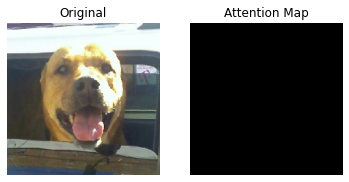

In [ ]:
from vit_keras import vit, utils, visualize

imgs = next(validation_generator)

attention_map = visualize.attention_map(model=model3, image=imgs[0][6])

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(imgs[0][5])
_ = ax2.imshow(attention_map)

In [ ]:
attention_map.max()

0

In [ ]:
base_model.layers

In [1]:
!pip install pytorch_lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

import numpy as np
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class patch_embbeding(nn.Module):
    """
    patch embeddingレイヤ
    
    画像をパッチに分割し線形変換を行いtransformerへの入力とする
    [cls]トークンをパッチの系列の先頭に追加し、これがencodingさたものを全結合層の入力とする
    学習可能な重みでpositional encoding
    """
    def __init__(self, img_size, patch_size=4, hidden_dim=8):
        """
        img_size : 画像のサイズ(height, width)
        patch_size : パッチサイズ
        hidden_dim : embedding後の次元
        """
        super().__init__()
        self.D = hidden_dim
        
        # 畳み込み層のkernelとstrideをpatch_sizeとすることで分割と線形変換を同時に行う
        self.patch_conv = nn.Conv2d(in_channels=3, out_channels=hidden_dim, kernel_size = patch_size, stride=patch_size)
        
        # [class](クラストークン)追加
        # callの中でbatch_sizeに拡張
        self.cls_token = nn.Parameter(torch.randn(1,1,hidden_dim))

        # position encoding
        # クラストークンの分も入れたshapeを指定
        N = int(img_size[0]*img_size[1]/(patch_size*patch_size))+1 # パッチの数+1(クラストークン)
        self.position = nn.Parameter(torch.randn(1,N,hidden_dim))
        
    def forward(self, inputs):
        """
        inputs: [batch_size,channel,height,width]
        """
        # batch_sizeの取得
        batch_size = inputs.size()[0]
        
        # パッチへの分割→線形変換
        # 畳み込み層のkernelとstrideをpatch_sizeとすることで同時に行う
        # [batch_size,channel,height,width]→[batch_size,hidden_dim,height/patch_size,width/patch_size]
        out = self.patch_conv(inputs)
        
        # [batch_size,hidden_dim,height/patch_size,width/patch_size]
        #      →[batch_size,hidden_dim,height*width/patch_size^2]
        #           →[batch_size,height*width/patch_size^2,hidden_dim]
        out = out.flatten(2).transpose(1,2)
        
        # クラストークンの拡張
        # [1,1,hidden_dim]→[batch_size,1,hidden_dim]
        cls_token = self.cls_token.repeat(repeats=(batch_size,1,1))
        
        # クラストークンをパッチ系列へ追加
        # [batch_size,height*width/patch_size^2,hidden_dim] + [batch_size,1,hidden_dim]
        #      → [batch_size,height*width/patch_size^2+1,hidden_dim]
        out = torch.cat([cls_token, out], dim=1)
        
        # positional encoding
        out = out+self.position 
        return out


class SelfMultiHeadAttention(nn.Module):
    '''
    Multi-Head Attentionレイヤ

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, drop_rate=0.5):
        '''
        Multi-Head Attentionレイヤ
    
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : マルチヘッドAttentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super(SelfMultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key   = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        
        # 出力の線形変換
        self.projection = nn.Linear(hidden_dim, hidden_dim)
        
        # 出力のDropout
        self.drop = nn.Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value):
        """
        Attention
        
        query, key, value : クエリ、キー、バリュー
            query [batch_size, head_num, q_length, hidden_dim//head_num]
            key, value [batch_size, head_num, m_length, hidden_dim//head_num]
            ただし、encoder:q_length=m_length
        """
        # 各値を取得
        shape = query.shape
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # 系列長
        hidden_dim = shape[1]*shape[3] # 入力チャンネル数
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [batch_size, head_num, q_length, hidden_dim/head_num] @ [batch_size, head_num, hidden_dim/head_num, m_length] = [batch_size, head_num, q_length, m_length]
        scores = torch.matmul(query, key.transpose(-2, -1))
        
        # scoreをhidden_dimの平方根割る
        scores = scores / math.sqrt(hidden_dim)

        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = F.softmax(scores, dim = -1)
        #atten_weight = scores / torch.sum(scores, dim=-1, keepdim=True)
        
        # 重みに従って value から情報を引いてきます
        # [batch_size, head_num, q_length, m_length] @ [batch_size, head_num, m_length, hidden_dim/head_num] = [batch_size, head_num, q_length, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = torch.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        # [batch_size, head_num, q_length, hidden_dim/head_num] -> [batch_size, q_length, head_num, hidden_dim/head_num]
        context = context.transpose(1, 2).contiguous()
        # [batch_size, q_length, head_num, hidden_dim/head_num] -> [batch_size, q_length, hidden_dim]
        context = context.view(batch_size, token_num, hidden_dim)
        
        # 線形変換
        context = self.projection(context)
        
        return self.drop(context), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim] の時
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape
        batch_size = -1 if shape[0] is None else shape[0]
        length = shape[1] # 系列長
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = x.view(batch_size, length, heads_num, int(hidden_dim/heads_num))
        
        # [batch_size, (q|m)_length, head_num, hidden_dim/head_num] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        x = x.transpose(1, 2)
        return x
    
    def forward(self, x, memory=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x
        
        # input -> query
        # memory -> key, value
        # [batch_size, (q|m)_length, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, (q|m)_length, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, q_length, hidden_dim]
        context, atten_weight = self.atten(query, key, value)
        
        if return_attention_scores:
            return context, atten_weight
        else:
            return context

class FeedForwardNetwork(nn.Module):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate=0.1):
        '''
        hidden_dim : Embeddingされた単語ベクトルの長さ
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = nn.Linear(hidden_dim, hidden_dim * 4)
        self.gelu = nn.GELU()
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = nn.Linear(hidden_dim * 4, hidden_dim)
        self.drop = nn.Dropout(drop_rate)

    def forward(self, x):
        '''
        入力と出力で形が変わらない
        x : 入力 [batch_size, length, hidden_dim]
        '''
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.gelu(x)
        x = self.drop(x)
        
        # [batch_size, (q|m)_length, 4*hidden_dim] -> [batch_size, (q|m)_length, hidden_dim]
        return self.output_dense_layer(x)

class ResidualNormalizationWrapper(nn.Module):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, hidden_dim, drop_rate=0.1):
        '''
        layer : 残渣接続したいレイヤ(MultiHeadAttentionかFeedForwardNetwork)に適用
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = nn.LayerNorm(hidden_dim)
        self.drop = nn.Dropout(drop_rate)

    def forward(self, x, memory=None, return_attention_scores=False):
        """
        モデルの実行
        
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのlengthと異なる場合がある
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            # attention weightを返す
            out, attn_weights = self.layer(out,**params)
            out = self.drop(out)
            return x + out, attn_weights
        else:
            # attention weightを返さない
            out = self.layer(out,**params)
            out = self.drop(out)
            return x + out

class EncoderLayer(nn.Module):
    """
    Encoderレイヤ
    　MultiHeadAttentionとFeedForwardNetworkの組み合わせ
      それぞれ残差接続されている
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.1):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # Multi-head attention
        self.atten = ResidualNormalizationWrapper(
            hidden_dim=hidden_dim,
            layer = SelfMultiHeadAttention(hidden_dim = hidden_dim,
                                           heads_num = heads_num,
                                           drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # Feed Forward Network
        self.ffn = ResidualNormalizationWrapper(
            hidden_dim=hidden_dim,
            layer = FeedForwardNetwork(hidden_dim = hidden_dim,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def forward(self, input, memory=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        if return_attention_scores:
            x, attn_weights = self.atten(input, memory, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, memory, return_attention_scores)
            x = self.ffn(x)
            return x

class Encoder(nn.Module):
    '''
    TransformerのEncoder
    '''
    def __init__(self, img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        img_size : 画像のサイズ
        patch_size : 画像を分割するサイズ
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # patch Embedding
        self.patch_embedding = patch_embbeding(img_size=img_size, patch_size=patch_size, hidden_dim=hidden_dim)
        self.input_dropout_layer = nn.Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = nn.ModuleList([EncoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)])
        self.output_normalization = nn.LayerNorm(hidden_dim)

    def forward(self, input, return_attention_scores=False):
        '''
        input: 入力 [batch_size,height,width,channel]
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, q_length, hidden_dim]
        '''
        # patch Embedding
        # [batch_size,height,width,channel] → [batch_size, q_length, hidden_dim]
        embedded_input = self.patch_embedding(input)
        query = self.input_dropout_layer(embedded_input)
        
        # Encoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, return_attention_scores=return_attention_scores)

            #  [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, return_attention_scores=return_attention_scores)
            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

class VisionTransformer(nn.Module):
    """
    Vision Transformer
    
    """
    def __init__(self, img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        patch_size : 画像を分割するサイズ
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()        
        self.encoder = Encoder(img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate)
        self.dense1 = nn.Linear(hidden_dim, 16)
        self.act1 = nn.Tanh()
        self.dropout1 = nn.Dropout(drop_rate)   
        self.final_layer = nn.Linear(16, 2)
        
        nn.init.normal_(self.dense1.weight, std=0.02)
        nn.init.normal_(self.dense1.bias, std=0)
        nn.init.normal_(self.final_layer.weight, std=0.02)
        nn.init.normal_(self.final_layer.bias, std=0)

    def forward(self, inputs, return_attention_scores=False):
        '''
        inputs: 入力(encoder, decoder)
        return_attention_scores : attention weightを出力するか
        '''
        # enc_input : [batch_size,height,width,channel]
        if return_attention_scores:
            enc_output, atten_weights = self.encoder(inputs, return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(inputs, return_attention_scores=return_attention_scores)
        
        # クラストークン部分のみ使用
        # [batch_size, enc_length, hidden_dim] -> [batch_size, hidden_dim]
        enc_output = self.dense1(enc_output[:, 0, :])
        enc_output = self.act1(enc_output)
        enc_output = self.dropout1(enc_output)
        final_output = self.final_layer(enc_output)

        if return_attention_scores:
            return final_output, atten_weights
        else:
            return final_output

In [ ]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = VisionTransformer(img_size=(224,224), patch_size=4, hopping_num=4, heads_num=2, hidden_dim=32, drop_rate=0.1)
model.to("cpu")

#summary(model, (3,224,224))

cuda:0


VisionTransformer(
  (encoder): Encoder(
    (patch_embedding): patch_embbeding(
      (patch_conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(4, 4))
    )
    (input_dropout_layer): Dropout(p=0.1, inplace=False)
    (attention_block_list): ModuleList(
      (0): EncoderLayer(
        (atten): ResidualNormalizationWrapper(
          (layer): SelfMultiHeadAttention(
            (query): Linear(in_features=32, out_features=32, bias=True)
            (key): Linear(in_features=32, out_features=32, bias=True)
            (value): Linear(in_features=32, out_features=32, bias=True)
            (projection): Linear(in_features=32, out_features=32, bias=True)
            (drop): Dropout(p=0.1, inplace=False)
          )
          (layer_normalization): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (ffn): ResidualNormalizationWrapper(
          (layer): FeedForwardNetwork(
            (filter_dense_layer): Linear(in_feature

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [2]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

In [4]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, train_path=None, val_path=None, test_path=None, batch_size=32):
        super().__init__()
        self.batch_size=batch_size
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3 / 4, 4 / 3)),
            transforms.RandomRotation([-10, 10]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        self.val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def setup(self, stage=None):
      if stage=='fit':
        self.train_dataset = datasets.ImageFolder(self.train_path, self.train_transform)
        self.val_dataset  = datasets.ImageFolder(self.val_path, self.val_transform)
      else:
        self.test_dataset  = datasets.ImageFolder(self.test_path, self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,num_workers=3, shuffle=True)
 
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,num_workers=3, shuffle=True)
 
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,num_workers=3, shuffle=True)

In [5]:
!pip install pytorch_lightning
import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

class ViTTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        model = VisionTransformer(img_size=(224,224), patch_size=8, hopping_num=4, heads_num=2, hidden_dim=32, drop_rate=0.1)
        model.to(device)
        model.train()
        model.apply(weights_init)
        self.model = model
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self, x):
        x = x.to(device)
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y)
        self.training_step_outputs.append({'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)})
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y)
        self.validation_step_outputs.append({'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)})
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy(task="binary")(y_label, y)
        self.test_step_outputs.append({'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)})
        return {'test_loss': loss, 'test_acc': acc}
    
    def on_train_epoch_end(self):
        y_hat = torch.cat([val['y_hat'] for val in self.training_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in self.training_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in self.training_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy(task="binary")(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loss, acc))
    
    def on_validation_epoch_end(self):
        y_hat = torch.cat([val['y_hat'] for val in self.validation_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in self.validation_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in self.validation_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)

        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy(task="binary")(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def on_test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in self.test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in self.test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in self.test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy(task="binary")(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
      learning_rate = 1e-3
      #optimizer = optimizers.Adam(self.model.parameters(), weight_decay=0.1)
      optimizer = optimizers.Adam(net.parameters(), lr=learning_rate, amsgrad=True, eps=1e-07)
      return optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dm = MyDataModule(train_path='/content/drive/MyDrive/dogcat_mini/train',
                  val_path='/content/drive/MyDrive/dogcat_mini/val',
                  test_path='/content/drive/MyDrive/dogcat_mini/test',
                  batch_size=25)
dm.setup()

net = VGGTrainer().to(device)

trainer = pl.Trainer(devices=1,max_epochs=200, accelerator="gpu")
trainer.fit(net, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params
--------------------------------------------
0 | model | VisionTransformer | 82.8 K
--------------------------------------------
82.8 K    Trainable params
0         Non-trainable params
82.8 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

valid Loss: 0.7719 valid Acc: 0.4200


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

valid Loss: 0.6937 valid Acc: 0.5141
---------- Current Epoch 1 ----------
train Loss: 0.7337 train Acc: 0.4922


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6918 valid Acc: 0.5380
---------- Current Epoch 2 ----------
train Loss: 0.7172 train Acc: 0.5156


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6864 valid Acc: 0.5590
---------- Current Epoch 3 ----------
train Loss: 0.7124 train Acc: 0.5246


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6826 valid Acc: 0.5641
---------- Current Epoch 4 ----------
train Loss: 0.7062 train Acc: 0.5317


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6806 valid Acc: 0.5622
---------- Current Epoch 5 ----------
train Loss: 0.7010 train Acc: 0.5380


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6756 valid Acc: 0.5707
---------- Current Epoch 6 ----------
train Loss: 0.6962 train Acc: 0.5434


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6720 valid Acc: 0.5759
---------- Current Epoch 7 ----------
train Loss: 0.6918 train Acc: 0.5484


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6675 valid Acc: 0.5826
---------- Current Epoch 8 ----------
train Loss: 0.6876 train Acc: 0.5556


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6666 valid Acc: 0.5848
---------- Current Epoch 9 ----------
train Loss: 0.6835 train Acc: 0.5615


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6630 valid Acc: 0.5907
---------- Current Epoch 10 ----------
train Loss: 0.6809 train Acc: 0.5650


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6591 valid Acc: 0.5951
---------- Current Epoch 11 ----------
train Loss: 0.6774 train Acc: 0.5701


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6552 valid Acc: 0.6000
---------- Current Epoch 12 ----------
train Loss: 0.6746 train Acc: 0.5742


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6516 valid Acc: 0.6047
---------- Current Epoch 13 ----------
train Loss: 0.6720 train Acc: 0.5784


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6484 valid Acc: 0.6084
---------- Current Epoch 14 ----------
train Loss: 0.6694 train Acc: 0.5822


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6466 valid Acc: 0.6111
---------- Current Epoch 15 ----------
train Loss: 0.6670 train Acc: 0.5858


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6435 valid Acc: 0.6154
---------- Current Epoch 16 ----------
train Loss: 0.6640 train Acc: 0.5904


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6422 valid Acc: 0.6171
---------- Current Epoch 17 ----------
train Loss: 0.6613 train Acc: 0.5938


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6391 valid Acc: 0.6209
---------- Current Epoch 18 ----------
train Loss: 0.6590 train Acc: 0.5969


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6372 valid Acc: 0.6235
---------- Current Epoch 19 ----------
train Loss: 0.6565 train Acc: 0.6005


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6350 valid Acc: 0.6264
---------- Current Epoch 20 ----------
train Loss: 0.6543 train Acc: 0.6035


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6326 valid Acc: 0.6291
---------- Current Epoch 21 ----------
train Loss: 0.6518 train Acc: 0.6068


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6307 valid Acc: 0.6312
---------- Current Epoch 22 ----------
train Loss: 0.6497 train Acc: 0.6098


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6295 valid Acc: 0.6334
---------- Current Epoch 23 ----------
train Loss: 0.6477 train Acc: 0.6122


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6277 valid Acc: 0.6355
---------- Current Epoch 24 ----------
train Loss: 0.6457 train Acc: 0.6148


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6269 valid Acc: 0.6371
---------- Current Epoch 25 ----------
train Loss: 0.6436 train Acc: 0.6170


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6258 valid Acc: 0.6384
---------- Current Epoch 26 ----------
train Loss: 0.6421 train Acc: 0.6192


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6243 valid Acc: 0.6403
---------- Current Epoch 27 ----------
train Loss: 0.6404 train Acc: 0.6212


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6231 valid Acc: 0.6417
---------- Current Epoch 28 ----------
train Loss: 0.6388 train Acc: 0.6232


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6222 valid Acc: 0.6428
---------- Current Epoch 29 ----------
train Loss: 0.6372 train Acc: 0.6250


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6257 valid Acc: 0.6413
---------- Current Epoch 30 ----------
train Loss: 0.6356 train Acc: 0.6269


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6249 valid Acc: 0.6421
---------- Current Epoch 31 ----------
train Loss: 0.6342 train Acc: 0.6285


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6232 valid Acc: 0.6441
---------- Current Epoch 32 ----------
train Loss: 0.6328 train Acc: 0.6300


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6217 valid Acc: 0.6453
---------- Current Epoch 33 ----------
train Loss: 0.6314 train Acc: 0.6318


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6223 valid Acc: 0.6460
---------- Current Epoch 34 ----------
train Loss: 0.6300 train Acc: 0.6335


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6214 valid Acc: 0.6470
---------- Current Epoch 35 ----------
train Loss: 0.6287 train Acc: 0.6350


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6203 valid Acc: 0.6481
---------- Current Epoch 36 ----------
train Loss: 0.6274 train Acc: 0.6364


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6189 valid Acc: 0.6495
---------- Current Epoch 37 ----------
train Loss: 0.6258 train Acc: 0.6382


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6180 valid Acc: 0.6507
---------- Current Epoch 38 ----------
train Loss: 0.6245 train Acc: 0.6398


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6191 valid Acc: 0.6504
---------- Current Epoch 39 ----------
train Loss: 0.6234 train Acc: 0.6410


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6181 valid Acc: 0.6516
---------- Current Epoch 40 ----------
train Loss: 0.6222 train Acc: 0.6424


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6170 valid Acc: 0.6530
---------- Current Epoch 41 ----------
train Loss: 0.6210 train Acc: 0.6438


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6163 valid Acc: 0.6540
---------- Current Epoch 42 ----------
train Loss: 0.6197 train Acc: 0.6455


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6158 valid Acc: 0.6551
---------- Current Epoch 43 ----------
train Loss: 0.6185 train Acc: 0.6467


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6161 valid Acc: 0.6551
---------- Current Epoch 44 ----------
train Loss: 0.6174 train Acc: 0.6480


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6153 valid Acc: 0.6560
---------- Current Epoch 45 ----------
train Loss: 0.6162 train Acc: 0.6493


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6143 valid Acc: 0.6567
---------- Current Epoch 46 ----------
train Loss: 0.6152 train Acc: 0.6504


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6140 valid Acc: 0.6572
---------- Current Epoch 47 ----------
train Loss: 0.6142 train Acc: 0.6514


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6139 valid Acc: 0.6575
---------- Current Epoch 48 ----------
train Loss: 0.6132 train Acc: 0.6525


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6133 valid Acc: 0.6585
---------- Current Epoch 49 ----------
train Loss: 0.6120 train Acc: 0.6538


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6125 valid Acc: 0.6595
---------- Current Epoch 50 ----------
train Loss: 0.6110 train Acc: 0.6548


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6116 valid Acc: 0.6604
---------- Current Epoch 51 ----------
train Loss: 0.6100 train Acc: 0.6559


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6117 valid Acc: 0.6608
---------- Current Epoch 52 ----------
train Loss: 0.6091 train Acc: 0.6569


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6108 valid Acc: 0.6618
---------- Current Epoch 53 ----------
train Loss: 0.6081 train Acc: 0.6580


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6099 valid Acc: 0.6627
---------- Current Epoch 54 ----------
train Loss: 0.6071 train Acc: 0.6590


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6093 valid Acc: 0.6635
---------- Current Epoch 55 ----------
train Loss: 0.6062 train Acc: 0.6598


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6083 valid Acc: 0.6644
---------- Current Epoch 56 ----------
train Loss: 0.6053 train Acc: 0.6607


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6081 valid Acc: 0.6651
---------- Current Epoch 57 ----------
train Loss: 0.6043 train Acc: 0.6618


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6085 valid Acc: 0.6653
---------- Current Epoch 58 ----------
train Loss: 0.6035 train Acc: 0.6626


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6078 valid Acc: 0.6661
---------- Current Epoch 59 ----------
train Loss: 0.6027 train Acc: 0.6634


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6072 valid Acc: 0.6669
---------- Current Epoch 60 ----------
train Loss: 0.6019 train Acc: 0.6643


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6069 valid Acc: 0.6675
---------- Current Epoch 61 ----------
train Loss: 0.6010 train Acc: 0.6650


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6072 valid Acc: 0.6677
---------- Current Epoch 62 ----------
train Loss: 0.6001 train Acc: 0.6660


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6082 valid Acc: 0.6677
---------- Current Epoch 63 ----------
train Loss: 0.5993 train Acc: 0.6668


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6076 valid Acc: 0.6685
---------- Current Epoch 64 ----------
train Loss: 0.5983 train Acc: 0.6678


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6070 valid Acc: 0.6691
---------- Current Epoch 65 ----------
train Loss: 0.5976 train Acc: 0.6685


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6071 valid Acc: 0.6694
---------- Current Epoch 66 ----------
train Loss: 0.5967 train Acc: 0.6693


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6065 valid Acc: 0.6702
---------- Current Epoch 67 ----------
train Loss: 0.5960 train Acc: 0.6701


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6064 valid Acc: 0.6707
---------- Current Epoch 68 ----------
train Loss: 0.5952 train Acc: 0.6709


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6060 valid Acc: 0.6715
---------- Current Epoch 69 ----------
train Loss: 0.5944 train Acc: 0.6716


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6055 valid Acc: 0.6720
---------- Current Epoch 70 ----------
train Loss: 0.5937 train Acc: 0.6722


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6056 valid Acc: 0.6722
---------- Current Epoch 71 ----------
train Loss: 0.5929 train Acc: 0.6731


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6055 valid Acc: 0.6728
---------- Current Epoch 72 ----------
train Loss: 0.5921 train Acc: 0.6738


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6051 valid Acc: 0.6734
---------- Current Epoch 73 ----------
train Loss: 0.5914 train Acc: 0.6744


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6044 valid Acc: 0.6741
---------- Current Epoch 74 ----------
train Loss: 0.5906 train Acc: 0.6752


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6036 valid Acc: 0.6748
---------- Current Epoch 75 ----------
train Loss: 0.5898 train Acc: 0.6760


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6036 valid Acc: 0.6751
---------- Current Epoch 76 ----------
train Loss: 0.5891 train Acc: 0.6768


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6030 valid Acc: 0.6758
---------- Current Epoch 77 ----------
train Loss: 0.5883 train Acc: 0.6776


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6026 valid Acc: 0.6763
---------- Current Epoch 78 ----------
train Loss: 0.5876 train Acc: 0.6782


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6023 valid Acc: 0.6769
---------- Current Epoch 79 ----------
train Loss: 0.5869 train Acc: 0.6789


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6019 valid Acc: 0.6774
---------- Current Epoch 80 ----------
train Loss: 0.5861 train Acc: 0.6797


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6021 valid Acc: 0.6777
---------- Current Epoch 81 ----------
train Loss: 0.5853 train Acc: 0.6805


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6016 valid Acc: 0.6784
---------- Current Epoch 82 ----------
train Loss: 0.5846 train Acc: 0.6812


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6010 valid Acc: 0.6788
---------- Current Epoch 83 ----------
train Loss: 0.5839 train Acc: 0.6818


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6005 valid Acc: 0.6794
---------- Current Epoch 84 ----------
train Loss: 0.5832 train Acc: 0.6824


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6002 valid Acc: 0.6799
---------- Current Epoch 85 ----------
train Loss: 0.5825 train Acc: 0.6831


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6001 valid Acc: 0.6804
---------- Current Epoch 86 ----------
train Loss: 0.5818 train Acc: 0.6836


Validation: 0it [00:00, ?it/s]

valid Loss: 0.6002 valid Acc: 0.6806
---------- Current Epoch 87 ----------
train Loss: 0.5811 train Acc: 0.6843


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5998 valid Acc: 0.6809
---------- Current Epoch 88 ----------
train Loss: 0.5804 train Acc: 0.6849


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5995 valid Acc: 0.6815
---------- Current Epoch 89 ----------
train Loss: 0.5798 train Acc: 0.6855


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5991 valid Acc: 0.6819
---------- Current Epoch 90 ----------
train Loss: 0.5792 train Acc: 0.6860


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5988 valid Acc: 0.6823
---------- Current Epoch 91 ----------
train Loss: 0.5785 train Acc: 0.6866


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5989 valid Acc: 0.6825
---------- Current Epoch 92 ----------
train Loss: 0.5778 train Acc: 0.6872


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5986 valid Acc: 0.6830
---------- Current Epoch 93 ----------
train Loss: 0.5771 train Acc: 0.6877


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5982 valid Acc: 0.6834
---------- Current Epoch 94 ----------
train Loss: 0.5765 train Acc: 0.6882


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5984 valid Acc: 0.6839
---------- Current Epoch 95 ----------
train Loss: 0.5759 train Acc: 0.6887


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5978 valid Acc: 0.6844
---------- Current Epoch 96 ----------
train Loss: 0.5752 train Acc: 0.6893


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5976 valid Acc: 0.6848
---------- Current Epoch 97 ----------
train Loss: 0.5747 train Acc: 0.6898


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5975 valid Acc: 0.6850
---------- Current Epoch 98 ----------
train Loss: 0.5741 train Acc: 0.6903


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5979 valid Acc: 0.6851
---------- Current Epoch 99 ----------
train Loss: 0.5734 train Acc: 0.6909


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5978 valid Acc: 0.6854
---------- Current Epoch 100 ----------
train Loss: 0.5728 train Acc: 0.6914


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5974 valid Acc: 0.6859
---------- Current Epoch 101 ----------
train Loss: 0.5722 train Acc: 0.6920


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5970 valid Acc: 0.6863
---------- Current Epoch 102 ----------
train Loss: 0.5716 train Acc: 0.6924


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5968 valid Acc: 0.6866
---------- Current Epoch 103 ----------
train Loss: 0.5711 train Acc: 0.6930


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5964 valid Acc: 0.6870
---------- Current Epoch 104 ----------
train Loss: 0.5706 train Acc: 0.6935


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5958 valid Acc: 0.6874
---------- Current Epoch 105 ----------
train Loss: 0.5700 train Acc: 0.6940


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5955 valid Acc: 0.6878
---------- Current Epoch 106 ----------
train Loss: 0.5695 train Acc: 0.6945


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5956 valid Acc: 0.6879
---------- Current Epoch 107 ----------
train Loss: 0.5689 train Acc: 0.6949


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5962 valid Acc: 0.6880
---------- Current Epoch 108 ----------
train Loss: 0.5683 train Acc: 0.6954


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5964 valid Acc: 0.6881
---------- Current Epoch 109 ----------
train Loss: 0.5676 train Acc: 0.6960


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5962 valid Acc: 0.6883
---------- Current Epoch 110 ----------
train Loss: 0.5671 train Acc: 0.6965


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5960 valid Acc: 0.6885
---------- Current Epoch 111 ----------
train Loss: 0.5666 train Acc: 0.6969


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5957 valid Acc: 0.6889
---------- Current Epoch 112 ----------
train Loss: 0.5660 train Acc: 0.6974


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5959 valid Acc: 0.6892
---------- Current Epoch 113 ----------
train Loss: 0.5654 train Acc: 0.6978


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5958 valid Acc: 0.6894
---------- Current Epoch 114 ----------
train Loss: 0.5649 train Acc: 0.6983


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5953 valid Acc: 0.6898
---------- Current Epoch 115 ----------
train Loss: 0.5643 train Acc: 0.6987


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5955 valid Acc: 0.6900
---------- Current Epoch 116 ----------
train Loss: 0.5638 train Acc: 0.6991


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5951 valid Acc: 0.6904
---------- Current Epoch 117 ----------
train Loss: 0.5633 train Acc: 0.6996


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5947 valid Acc: 0.6909
---------- Current Epoch 118 ----------
train Loss: 0.5627 train Acc: 0.7000


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5944 valid Acc: 0.6913
---------- Current Epoch 119 ----------
train Loss: 0.5622 train Acc: 0.7005


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5939 valid Acc: 0.6917
---------- Current Epoch 120 ----------
train Loss: 0.5616 train Acc: 0.7010


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5937 valid Acc: 0.6922
---------- Current Epoch 121 ----------
train Loss: 0.5612 train Acc: 0.7014


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5934 valid Acc: 0.6925
---------- Current Epoch 122 ----------
train Loss: 0.5606 train Acc: 0.7018


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5930 valid Acc: 0.6930
---------- Current Epoch 123 ----------
train Loss: 0.5601 train Acc: 0.7023


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5926 valid Acc: 0.6933
---------- Current Epoch 124 ----------
train Loss: 0.5596 train Acc: 0.7027


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5926 valid Acc: 0.6936
---------- Current Epoch 125 ----------
train Loss: 0.5590 train Acc: 0.7032


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5921 valid Acc: 0.6940
---------- Current Epoch 126 ----------
train Loss: 0.5585 train Acc: 0.7036


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5917 valid Acc: 0.6943
---------- Current Epoch 127 ----------
train Loss: 0.5580 train Acc: 0.7040


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5915 valid Acc: 0.6947
---------- Current Epoch 128 ----------
train Loss: 0.5575 train Acc: 0.7044


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5913 valid Acc: 0.6948
---------- Current Epoch 129 ----------
train Loss: 0.5571 train Acc: 0.7047


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5910 valid Acc: 0.6951
---------- Current Epoch 130 ----------
train Loss: 0.5565 train Acc: 0.7051


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5909 valid Acc: 0.6955
---------- Current Epoch 131 ----------
train Loss: 0.5560 train Acc: 0.7055


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5907 valid Acc: 0.6958
---------- Current Epoch 132 ----------
train Loss: 0.5555 train Acc: 0.7059


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5908 valid Acc: 0.6959
---------- Current Epoch 133 ----------
train Loss: 0.5550 train Acc: 0.7064


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5905 valid Acc: 0.6962
---------- Current Epoch 134 ----------
train Loss: 0.5545 train Acc: 0.7067


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5900 valid Acc: 0.6966
---------- Current Epoch 135 ----------
train Loss: 0.5541 train Acc: 0.7070


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5901 valid Acc: 0.6968
---------- Current Epoch 136 ----------
train Loss: 0.5537 train Acc: 0.7073


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5898 valid Acc: 0.6972
---------- Current Epoch 137 ----------
train Loss: 0.5532 train Acc: 0.7077


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5895 valid Acc: 0.6975
---------- Current Epoch 138 ----------
train Loss: 0.5527 train Acc: 0.7081


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5893 valid Acc: 0.6978
---------- Current Epoch 139 ----------
train Loss: 0.5523 train Acc: 0.7085


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5890 valid Acc: 0.6981
---------- Current Epoch 140 ----------
train Loss: 0.5518 train Acc: 0.7089


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5891 valid Acc: 0.6984
---------- Current Epoch 141 ----------
train Loss: 0.5513 train Acc: 0.7093


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5888 valid Acc: 0.6986
---------- Current Epoch 142 ----------
train Loss: 0.5508 train Acc: 0.7097


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5886 valid Acc: 0.6989
---------- Current Epoch 143 ----------
train Loss: 0.5503 train Acc: 0.7101


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5885 valid Acc: 0.6992
---------- Current Epoch 144 ----------
train Loss: 0.5499 train Acc: 0.7104


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5881 valid Acc: 0.6995
---------- Current Epoch 145 ----------
train Loss: 0.5494 train Acc: 0.7108


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5878 valid Acc: 0.6997
---------- Current Epoch 146 ----------
train Loss: 0.5490 train Acc: 0.7111


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5876 valid Acc: 0.7000
---------- Current Epoch 147 ----------
train Loss: 0.5485 train Acc: 0.7115


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5873 valid Acc: 0.7003
---------- Current Epoch 148 ----------
train Loss: 0.5480 train Acc: 0.7118


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5871 valid Acc: 0.7006
---------- Current Epoch 149 ----------
train Loss: 0.5476 train Acc: 0.7121


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5868 valid Acc: 0.7009
---------- Current Epoch 150 ----------
train Loss: 0.5472 train Acc: 0.7124


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5866 valid Acc: 0.7011
---------- Current Epoch 151 ----------
train Loss: 0.5467 train Acc: 0.7128


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5863 valid Acc: 0.7015
---------- Current Epoch 152 ----------
train Loss: 0.5463 train Acc: 0.7131


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5861 valid Acc: 0.7017
---------- Current Epoch 153 ----------
train Loss: 0.5458 train Acc: 0.7135


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5858 valid Acc: 0.7020
---------- Current Epoch 154 ----------
train Loss: 0.5453 train Acc: 0.7138


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5857 valid Acc: 0.7022
---------- Current Epoch 155 ----------
train Loss: 0.5449 train Acc: 0.7142


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5855 valid Acc: 0.7025
---------- Current Epoch 156 ----------
train Loss: 0.5444 train Acc: 0.7146


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5851 valid Acc: 0.7028
---------- Current Epoch 157 ----------
train Loss: 0.5440 train Acc: 0.7149


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5849 valid Acc: 0.7031
---------- Current Epoch 158 ----------
train Loss: 0.5435 train Acc: 0.7152


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5846 valid Acc: 0.7034
---------- Current Epoch 159 ----------
train Loss: 0.5431 train Acc: 0.7156


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5844 valid Acc: 0.7036
---------- Current Epoch 160 ----------
train Loss: 0.5426 train Acc: 0.7159


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5843 valid Acc: 0.7038
---------- Current Epoch 161 ----------
train Loss: 0.5423 train Acc: 0.7162


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5839 valid Acc: 0.7041
---------- Current Epoch 162 ----------
train Loss: 0.5418 train Acc: 0.7165


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5839 valid Acc: 0.7043
---------- Current Epoch 163 ----------
train Loss: 0.5413 train Acc: 0.7169


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5837 valid Acc: 0.7046
---------- Current Epoch 164 ----------
train Loss: 0.5409 train Acc: 0.7172


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5834 valid Acc: 0.7048
---------- Current Epoch 165 ----------
train Loss: 0.5405 train Acc: 0.7175


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5832 valid Acc: 0.7051
---------- Current Epoch 166 ----------
train Loss: 0.5401 train Acc: 0.7178


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5831 valid Acc: 0.7053
---------- Current Epoch 167 ----------
train Loss: 0.5397 train Acc: 0.7181


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5832 valid Acc: 0.7055
---------- Current Epoch 168 ----------
train Loss: 0.5392 train Acc: 0.7185


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5830 valid Acc: 0.7057
---------- Current Epoch 169 ----------
train Loss: 0.5387 train Acc: 0.7189


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5828 valid Acc: 0.7060
---------- Current Epoch 170 ----------
train Loss: 0.5383 train Acc: 0.7192


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5828 valid Acc: 0.7061
---------- Current Epoch 171 ----------
train Loss: 0.5379 train Acc: 0.7195


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5825 valid Acc: 0.7064
---------- Current Epoch 172 ----------
train Loss: 0.5375 train Acc: 0.7198


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5822 valid Acc: 0.7066
---------- Current Epoch 173 ----------
train Loss: 0.5371 train Acc: 0.7201


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5819 valid Acc: 0.7069
---------- Current Epoch 174 ----------
train Loss: 0.5366 train Acc: 0.7205


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5816 valid Acc: 0.7071
---------- Current Epoch 175 ----------
train Loss: 0.5362 train Acc: 0.7208


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5814 valid Acc: 0.7074
---------- Current Epoch 176 ----------
train Loss: 0.5358 train Acc: 0.7211


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5812 valid Acc: 0.7077
---------- Current Epoch 177 ----------
train Loss: 0.5354 train Acc: 0.7214


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5811 valid Acc: 0.7079
---------- Current Epoch 178 ----------
train Loss: 0.5349 train Acc: 0.7217


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5808 valid Acc: 0.7081
---------- Current Epoch 179 ----------
train Loss: 0.5346 train Acc: 0.7220


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5807 valid Acc: 0.7083
---------- Current Epoch 180 ----------
train Loss: 0.5342 train Acc: 0.7223


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5806 valid Acc: 0.7086
---------- Current Epoch 181 ----------
train Loss: 0.5338 train Acc: 0.7226


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5804 valid Acc: 0.7088
---------- Current Epoch 182 ----------
train Loss: 0.5334 train Acc: 0.7229


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5803 valid Acc: 0.7090
---------- Current Epoch 183 ----------
train Loss: 0.5330 train Acc: 0.7232


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5801 valid Acc: 0.7092
---------- Current Epoch 184 ----------
train Loss: 0.5326 train Acc: 0.7235


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5799 valid Acc: 0.7094
---------- Current Epoch 185 ----------
train Loss: 0.5322 train Acc: 0.7237


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5797 valid Acc: 0.7096
---------- Current Epoch 186 ----------
train Loss: 0.5318 train Acc: 0.7241


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5798 valid Acc: 0.7097
---------- Current Epoch 187 ----------
train Loss: 0.5314 train Acc: 0.7243


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5797 valid Acc: 0.7099
---------- Current Epoch 188 ----------
train Loss: 0.5310 train Acc: 0.7246


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5797 valid Acc: 0.7100
---------- Current Epoch 189 ----------
train Loss: 0.5306 train Acc: 0.7249


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5797 valid Acc: 0.7102
---------- Current Epoch 190 ----------
train Loss: 0.5303 train Acc: 0.7252


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5796 valid Acc: 0.7104
---------- Current Epoch 191 ----------
train Loss: 0.5299 train Acc: 0.7254


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5796 valid Acc: 0.7105
---------- Current Epoch 192 ----------
train Loss: 0.5295 train Acc: 0.7257


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5794 valid Acc: 0.7107
---------- Current Epoch 193 ----------
train Loss: 0.5292 train Acc: 0.7260


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5794 valid Acc: 0.7108
---------- Current Epoch 194 ----------
train Loss: 0.5288 train Acc: 0.7262


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5793 valid Acc: 0.7110
---------- Current Epoch 195 ----------
train Loss: 0.5284 train Acc: 0.7265


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5794 valid Acc: 0.7111
---------- Current Epoch 196 ----------
train Loss: 0.5280 train Acc: 0.7268


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5793 valid Acc: 0.7113
---------- Current Epoch 197 ----------
train Loss: 0.5277 train Acc: 0.7271


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5791 valid Acc: 0.7114
---------- Current Epoch 198 ----------
train Loss: 0.5274 train Acc: 0.7273


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5790 valid Acc: 0.7116
---------- Current Epoch 199 ----------
train Loss: 0.5270 train Acc: 0.7276


Validation: 0it [00:00, ?it/s]

valid Loss: 0.5790 valid Acc: 0.7117


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


---------- Current Epoch 200 ----------
train Loss: 0.5266 train Acc: 0.7279


In [9]:
test_imgs = dm.test_dataloader()
for i in test_imgs:
    imgs, labels = i

In [ ]:
pred, attentino_map = net.model.forward(imgs, return_attention_scores=True)

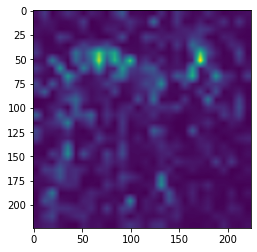

In [ ]:
import matplotlib.pyplot as plt
import cv2

plt.imshow(cv2.resize(attentino_map[20,:,1:,0].detach().numpy().mean(axis=0).reshape((int(224/8),int(224/8))), (224, 224)))

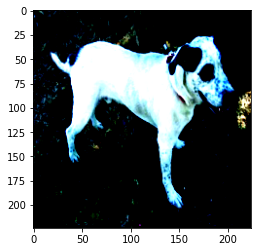

In [ ]:
plt.imshow(imgs[20].detach().numpy().transpose(1,2,0));

https://github.com/lucidrains/vit-pytorch

In [ ]:
import torchvision.models as models

class CustomVisionTransformer(nn.Module):
    """
    Vision Transformer
    
    """
    def __init__(self, drop_rate=0.1):
        '''
        patch_size : 画像を分割するサイズ
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()        
        self.encoder = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        for param in self.encoder.parameters():
          param.requires_grad = False

        hidden_dim = self.encoder.heads.head.in_features
        
        self.encoder.heads = nn.Sequential(
          nn.Linear(hidden_dim, 16),
          nn.Tanh(),
          nn.Dropout(drop_rate),
          nn.Linear(16, 2)
          )

    def forward(self, inputs):
        '''
        inputs: 入力(encoder, decoder)
        return_attention_scores : attention weightを出力するか
        '''
        final_output = self.encoder(inputs)
        return final_output

In [ ]:
#!pip install pytorch_lightning
import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

class ViTTrainer2(pl.LightningModule):
    def __init__(self):
        super().__init__()
        model = CustomVisionTransformer()
        model.to(device)
        self.model = model
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self, x):
        x = x.to(device)
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y)
        self.training_step_outputs.append({'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)})
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y)
        self.validation_step_outputs.append({'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)})
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy(task="binary")(y_label, y)
        self.test_step_outputs.append({'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)})
        return {'test_loss': loss, 'test_acc': acc}
    
    def on_train_epoch_end(self):
        y_hat = torch.cat([val['y_hat'] for val in self.training_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in self.training_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in self.training_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy(task="binary")(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loss, acc))
    
    def on_validation_epoch_end(self):
        y_hat = torch.cat([val['y_hat'] for val in self.validation_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in self.validation_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in self.validation_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)

        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy(task="binary")(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def on_test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in self.test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in self.test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in self.test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy(task="binary")(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
      learning_rate = 1e-3
      #optimizer = optimizers.Adam(self.model.parameters(), weight_decay=0.1)
      optimizer = optimizers.Adam(net.parameters(), lr=learning_rate, amsgrad=True, eps=1e-07)
      return optimizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dm = MyDataModule(train_path='/content/drive/MyDrive/dogcat_mini/train',
                  val_path='/content/drive/MyDrive/dogcat_mini/val',
                  test_path='/content/drive/MyDrive/dogcat_mini/test',
                  batch_size=25)
dm.setup()

net = ViTTrainer2().to(device)

trainer = pl.Trainer(devices=1,max_epochs=20, accelerator="gpu")
trainer.fit(net, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                    | Params
--------------------------------------------------
0 | model | CustomVisionTransformer | 85.8 M
--------------------------------------------------
12.3 K    Trainable params
85.8 M    Non-trainable params
85.8 M    Total params
343.244   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

valid Loss: 0.6422 valid Acc: 0.7400


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

valid Loss: 0.0578 valid Acc: 0.9834
---------- Current Epoch 1 ----------
train Loss: 0.0907 train Acc: 0.9782


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0472 valid Acc: 0.9869
---------- Current Epoch 2 ----------
train Loss: 0.0692 train Acc: 0.9810


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0429 valid Acc: 0.9884
---------- Current Epoch 3 ----------
train Loss: 0.0602 train Acc: 0.9819


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0409 valid Acc: 0.9892
---------- Current Epoch 4 ----------
train Loss: 0.0549 train Acc: 0.9828


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0396 valid Acc: 0.9896
---------- Current Epoch 5 ----------
train Loss: 0.0531 train Acc: 0.9827


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0393 valid Acc: 0.9895
---------- Current Epoch 6 ----------
train Loss: 0.0502 train Acc: 0.9835


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0394 valid Acc: 0.9893
---------- Current Epoch 7 ----------
train Loss: 0.0487 train Acc: 0.9835


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0391 valid Acc: 0.9895
---------- Current Epoch 8 ----------
train Loss: 0.0467 train Acc: 0.9840


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0391 valid Acc: 0.9895
---------- Current Epoch 9 ----------
train Loss: 0.0457 train Acc: 0.9843


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0391 valid Acc: 0.9896
---------- Current Epoch 10 ----------
train Loss: 0.0442 train Acc: 0.9847


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0389 valid Acc: 0.9897
---------- Current Epoch 11 ----------
train Loss: 0.0439 train Acc: 0.9847


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0389 valid Acc: 0.9896
---------- Current Epoch 12 ----------
train Loss: 0.0433 train Acc: 0.9849


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0388 valid Acc: 0.9896
---------- Current Epoch 13 ----------
train Loss: 0.0426 train Acc: 0.9852


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0386 valid Acc: 0.9897
---------- Current Epoch 14 ----------
train Loss: 0.0426 train Acc: 0.9851


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0383 valid Acc: 0.9897
---------- Current Epoch 15 ----------
train Loss: 0.0420 train Acc: 0.9853


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0383 valid Acc: 0.9898
---------- Current Epoch 16 ----------
train Loss: 0.0415 train Acc: 0.9855


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0381 valid Acc: 0.9898
---------- Current Epoch 17 ----------
train Loss: 0.0409 train Acc: 0.9856


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0379 valid Acc: 0.9899
---------- Current Epoch 18 ----------
train Loss: 0.0406 train Acc: 0.9857


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0376 valid Acc: 0.9899
---------- Current Epoch 19 ----------
train Loss: 0.0401 train Acc: 0.9859


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0374 valid Acc: 0.9900
---------- Current Epoch 20 ----------
train Loss: 0.0398 train Acc: 0.9858


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [19]:
!pip install transformers
from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

class CustomVisionTransformer2(nn.Module):
    """
    Vision Transformer
    
    """
    def __init__(self, drop_rate=0.1):
        '''
        patch_size : 画像を分割するサイズ
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()        
        self.encoder = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224",output_attentions=True)
        for param in self.encoder.parameters():
          param.requires_grad = False

        hidden_dim = self.encoder.classifier.in_features
        
        self.encoder.classifier = nn.Sequential(
          nn.Linear(hidden_dim, 16),
          nn.Tanh(),
          nn.Dropout(drop_rate),
          nn.Linear(16, 2)
          )

    def forward(self, inputs):
        '''
        inputs: 入力(encoder, decoder)
        return_attention_scores : attention weightを出力するか
        '''
        final_output = self.encoder(inputs)
        return final_output

class ViTTrainer3(pl.LightningModule):
    def __init__(self):
        super().__init__()
        model = CustomVisionTransformer2()
        model.to(device)
        self.model = model
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
    def forward(self, x):
        x = x.to(device)
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat.logits, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y)
        self.training_step_outputs.append({'loss': loss, 'y_hat':y_hat.logits, 'y':y, 'batch_loss': loss.item()*x.size(0)})
        return {'loss': loss, 'y_hat':y_hat.logits, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat.logits, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y)
        self.validation_step_outputs.append({'loss': loss, 'y_hat':y_hat.logits, 'y':y, 'batch_loss': loss.item()*x.size(0)})
        return {'y_hat':y_hat.logits, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat.logits, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy(task="binary")(y_label, y)
        self.test_step_outputs.append({'loss': loss, 'y_hat':y_hat.logits, 'y':y, 'batch_loss': loss.item()*x.size(0)})
        return {'test_loss': loss, 'test_acc': acc}
    
    def on_train_epoch_end(self):
        y_hat = torch.cat([val['y_hat'] for val in self.training_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in self.training_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in self.training_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy(task="binary")(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loss, acc))
    
    def on_validation_epoch_end(self):
        y_hat = torch.cat([val['y_hat'] for val in self.validation_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in self.validation_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in self.validation_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)

        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy(task="binary")(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def on_test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in self.test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in self.test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in self.test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        preds = preds.cpu()
        y = y.cpu()
        acc = accuracy(task="binary")(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
      learning_rate = 1e-3
      #optimizer = optimizers.Adam(self.model.parameters(), weight_decay=0.1)
      optimizer = optimizers.Adam(net.parameters(), lr=learning_rate, amsgrad=True, eps=1e-07)
      return optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dm = MyDataModule(train_path='/content/drive/MyDrive/dogcat_mini/train',
                  val_path='/content/drive/MyDrive/dogcat_mini/val',
                  test_path='/content/drive/MyDrive/dogcat_mini/test',
                  batch_size=25)
dm.setup()

net = ViTTrainer3().to(device)

trainer = pl.Trainer(devices=1,max_epochs=10, accelerator="gpu")
trainer.fit(net, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                     | Params
---------------------------------------------------
0 | model | CustomVisionTransformer2 | 85.8 M
---------------------------------------------------
12.3 K    Trainable params
85.8 M    Non-trainable params
85.8 M    Total params
343.244   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


valid Loss: 0.6992 valid Acc: 0.5200


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

valid Loss: 0.0488 valid Acc: 0.9780
---------- Current Epoch 1 ----------
train Loss: 0.1059 train Acc: 0.9604


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0404 valid Acc: 0.9840
---------- Current Epoch 2 ----------
train Loss: 0.0912 train Acc: 0.9652


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0372 valid Acc: 0.9861
---------- Current Epoch 3 ----------
train Loss: 0.0849 train Acc: 0.9670


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0365 valid Acc: 0.9868
---------- Current Epoch 4 ----------
train Loss: 0.0790 train Acc: 0.9688


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0357 valid Acc: 0.9876
---------- Current Epoch 5 ----------
train Loss: 0.0766 train Acc: 0.9696


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0351 valid Acc: 0.9883
---------- Current Epoch 6 ----------
train Loss: 0.0739 train Acc: 0.9707


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0344 valid Acc: 0.9885
---------- Current Epoch 7 ----------
train Loss: 0.0728 train Acc: 0.9711


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0334 valid Acc: 0.9888
---------- Current Epoch 8 ----------
train Loss: 0.0719 train Acc: 0.9714


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0333 valid Acc: 0.9889
---------- Current Epoch 9 ----------
train Loss: 0.0712 train Acc: 0.9718


Validation: 0it [00:00, ?it/s]

valid Loss: 0.0334 valid Acc: 0.9889
---------- Current Epoch 10 ----------
train Loss: 0.0701 train Acc: 0.9722


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [22]:
result = net.model.forward(imgs)

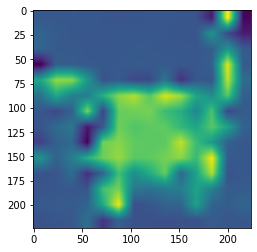

In [35]:
import matplotlib.pyplot as plt
import cv2

plt.imshow(cv2.resize(result.attentions[0][1,:,1:,0].detach().numpy().mean(axis=0).reshape((int(224/16),int(224/16))), (224, 224)))

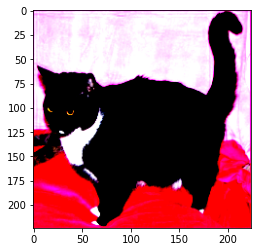

In [36]:
plt.imshow(imgs[1].detach().numpy().transpose(1,2,0))